<a href="https://colab.research.google.com/github/ScoobanyLoLo/Colab/blob/main/deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#CZĘŚĆ PIERWSZA
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Konfiguracja wyglądu wykresów: rozmiar i brak siatki
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
#CZĘŚĆ DRUGA
import tensorflow as tf
import pandas as pd
import os
import zipfile
# Pobieramy spakowany zbiór danych pogodowych
zip_path = tf.keras.utils.get_file(
origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
fname='jena_climate_2009_2016.csv.zip',
extract=False # NIE rozpakowujemy automatycznie
)
# Ścieżka do katalogu, gdzie zapisano plik
extract_path = os.path.dirname(zip_path)
# Ręcznie rozpakowujemy plik ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)
# Uzyskujemy poprawną ścieżkę do pliku CSV
csv_path = os.path.join(extract_path, 'jena_climate_2009_2016.csv')
# TEST: sprawdzamy, czy plik CSV istnieje
assert os.path.exists(csv_path), f"Plik {csv_path} nie istnieje!"
# Wczytujemy dane z pliku CSV do obiektu DataFrame
df = pd.read_csv(csv_path)
# Redukujemy zbiór danych, wybierając co 6-ty pomiar (zachowujemy tylko 1 pomiar na godzinę)
df = df[5::6]
# Konwertujemy kolumnę 'Date Time' na typ datetime i usuwamy ją z oryginalnej ramki danych
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos', 'wv (m/s)',
       'max wv (m/s)', 'wd (deg)'],
      dtype='object')


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

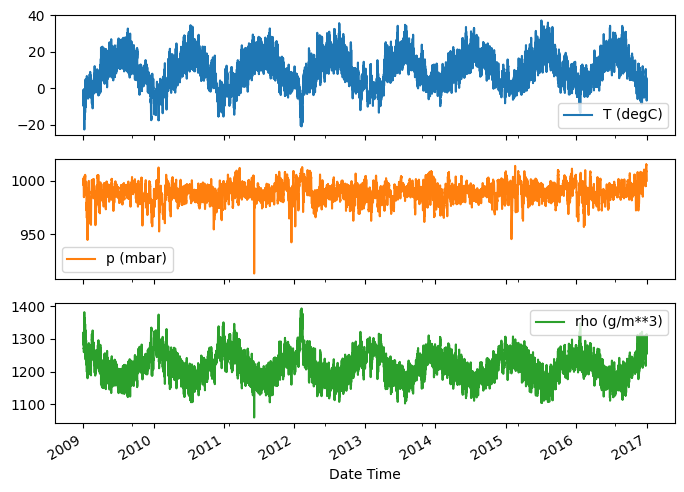

In [16]:
#CZĘŚĆ TRZECIA
# Wyświetlamy pierwsze kilka wierszy danych, aby sprawdzić strukturę
df.head()
# Wyświetlamy listę wszystkich kolumn dostępnych w zbiorze danych
print(df.columns)
# Rysujemy wykres pokazujący zmiany jednej z wybranych zmiennych w czasie (np. temperatury)
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
# Tworzymy wykres z trzema zmiennymi
plot_features.plot(subplots=True)

In [19]:

#Naprawiamy błędne wartości (-9999) w obliczonej prędkości
df['wv (m/s)'] = np.sqrt(df['Wx']**2 + df['Wy']**2)
df.loc[df['wv (m/s)'] == -9999.0, 'wv (m/s)'] = 0.0

#Obliczamy maksymalną prędkość wiatru z max Wx i max Wy
df['max wv (m/s)'] = np.sqrt(df['max Wx']**2 + df['max Wy']**2)

#Naprawiamy błędne wartości (-9999) w max prędkości
df.loc[df['max wv (m/s)'] == -9999.0, 'max wv (m/s)'] = 0.0

#(opcjonalnie) Oblicz kierunek wiatru (w stopniach), jeśli chcesz
df['wd (deg)'] = (np.degrees(np.arctan2(df['Wy'], df['Wx'])) + 360) % 360

#Czas - zakładamy, że masz kolumnę `date_time`
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24 * 60 * 60
year = 365.2425 * day

#Dodajemy zmienne czasowe sinusoidalne
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
